# L2 regularisation on a multilayer perceptron neural network
## In this lab I will demonstrate the impact and importance of regularisation on neural networks by modelling the factors that impact a vehicles fuel efficiency using data from kaggle.com. I will further demonstrate the use of neural networks in setting design guidelines for the automotive industry and dive into the consequences that can result in using an inaccurate model. 
## Insights and suggestions are based on the results of a response curve.
## The flexibility of neural networks allows it to model non-linear relationships and capture the true relationship and patterns in the data. 
### **Importing libraries and loading data**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import itertools

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
auto = pd.read_csv('auto-mpg.csv')
auto.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
111,18.0,3,70.0,90,2124,13.5,73,3,maxda rx3
218,36.0,4,79.0,58,1825,18.6,77,2,renault 5 gtl
327,36.4,5,121.0,67,2950,19.9,80,2,audi 5000s (diesel)
76,18.0,4,121.0,112,2933,14.5,72,2,volvo 145e (sw)
234,24.5,4,151.0,88,2740,16.0,77,1,pontiac sunbird coupe


In [6]:
print(auto.shape)
print('Null values:', auto.isna().sum().sum())
print(' ')
print(auto.info())

(398, 9)
Null values: 0
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None


### The attribute `horsepower` is an object data type instead of int. This indicates that there are possible invalid entries.
### **Data cleaning**

In [7]:
# Common data issue
auto[auto['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


In [8]:
auto = auto.replace('?', np.nan)
auto.dropna(inplace= True)
auto['horsepower'] = auto['horsepower'].astype('int')

print(auto.shape)
print('Null values:', auto.isna().sum().sum())
print('Horsepower data type is', auto['horsepower'].dtype)

(392, 9)
Null values: 0
Horsepower data type is int32


### There were only 6 invalid entries which has now been removed and converted the horsepower feature into its correct data type. This leaves us with 392 vehicles with 8 features that impacts a vehicles fuel effeciency.
### **Feature selection and scaling**
### All features except car name will be used in the neural network to model the relationships affecting a vehicles fuel effeciency. This will then be split into a training and test set to determine the performance of our model.

In [9]:
X = auto.drop(columns= ['mpg', 'car name'])
y = auto['mpg']

y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 0) 

### Feature scaling is useful in improving the training process and the overall performance of the model. This is done by weighting data on the same scale to prevent larger values from dominating the model.

In [10]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### **Parameter tuning**
### This model will make use of one hidden layer. In order to determine the optimal nodes in the hidden layer, I will use the k-fold cross-validation approach. The node with the highest validation score will be selected.
### This is then followed by calculating the mean squared error (mse) on the test data before regularisation.

In [11]:
val_score = {}
print('Nodes: Score')

for hidden_layer_node in range(4, 7):
    mlpr = MLPRegressor(max_iter= 1200, solver= 'lbfgs', activation= 'tanh',
                        hidden_layer_sizes= hidden_layer_node, random_state= 1)
    
    score = cross_val_score(estimator= mlpr, X= X_train, y= y_train, cv= 5)
    val_score[hidden_layer_node] = score.mean()
    
    print(hidden_layer_node, ': %0.3f' % val_score[hidden_layer_node])
print(' ')
print('Optimal node gives us a score of', ': %0.3f' % max(val_score.values()))
best_node = max(val_score, key= val_score.get)
print("This corresponds to %s nodes" % best_node)

Nodes: Score
4 : 0.734
5 : 0.800
6 : 0.811
 
Optimal node gives us a score of : 0.811
This corresponds to 6 nodes


In [12]:
mlpr = MLPRegressor(max_iter= 1200, solver= 'lbfgs', activation= 'tanh',
                    hidden_layer_sizes= (6), random_state= 1)
mlpr = mlpr.fit(X_train, y_train)

y_pred = mlpr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean sqaured error:', ': %0.3f' % (mse))

Mean sqaured error: : 10.940


### Through cross-validation, it is determined that the optimal nodes to use in the network is 6 . This results to the model having a mean sqaured error of 10.940 on our test data.
### **L2 regularisation**
### I will apply L2 regularisation by tuning the `alpha` hyperparameter and selecting the value that results to the lowest mse on the training set.
### L2 regularisation is a technique used to avoid overfitting the noise in the data. This is done by introducing a penalty term to the cost function to regulate the weights in the neural network. This is achieved by pushing large weights in the network closer to 0, this phenomenon is known as weight decay.

In [13]:
reg_par = [np.e**n for n in np.arange(-3,6,1)] 

# Optimise neural network with regularisation
val_scores1 = {}
print(" alpha  |  Sq.Error")  

for param in reg_par:
    mlpr1 = MLPRegressor(max_iter= 12000, solver= 'lbfgs', activation= 'tanh', 
                        hidden_layer_sizes= (6), alpha= param, random_state= 1)
    score1 = cross_val_score(estimator= mlpr1, X= X_train, y= y_train, 
                            cv= 5, scoring= "neg_mean_squared_error")
    val_scores1[param] = -score1.mean()
    print("%0.5f |  %0.6f" % (param, -score1.mean()))

print(' ')
print("The lowest cross validation error is %f" % min(val_scores1.values()))
best_reg_param = min(val_scores1, key= val_scores1.get)
print("This corresponds to regularisation parameter e**%s" % np.log(best_reg_param))

 alpha  |  Sq.Error
0.04979 |  11.769499
0.13534 |  11.560965
0.36788 |  9.217541
1.00000 |  9.076877
2.71828 |  8.214131
7.38906 |  7.583204
20.08554 |  7.776923
54.59815 |  9.968656
148.41316 |  15.211338
 
The lowest cross validation error is 7.583204
This corresponds to regularisation parameter e**2.0


### By comparing the mse, we find that the optimal value for alpha is 2 which provides the lowest mse on the training data. This will be used for the final model to observe if there is any changes on the mse for the test data.
### Below is a visual representation of this test for lowest mse.

Text(0, 0.5, 'Mean Sq Error')

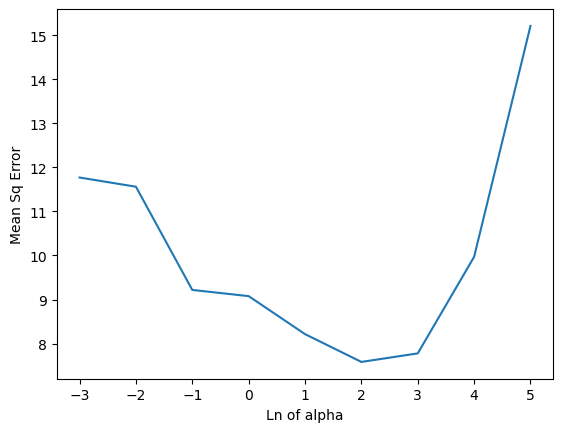

In [14]:
plt.plot([np.log(i) for i in val_scores1.keys()], list(val_scores1.values()))
plt.xlabel("Ln of alpha")
plt.ylabel("Mean Sq Error")

In [15]:
mlpr1 = MLPRegressor(max_iter= 1200, solver= 'lbfgs', activation= 'tanh',
                    hidden_layer_sizes= (6), alpha= 2, random_state= 1)
mlpr1 = mlpr1.fit(X_train, y_train)

y_pred1 = mlpr1.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred1)
print('Mean sqaured error:', ': %0.3f' % (mse1))

Mean sqaured error: : 9.080


### We observe a decrease in mse on the test data from 10.940 to an mse of 9.080, this indicates an improved model that can better generalize on unseen data and provide more accurate predictions.
### The decrease in mse underlines the value of regularisation on neural networks. By capturing the true relationship and patterns in the data the results are more reliable and useable in real life contexts.
### **Using response curve for design guidelines**
### I will demonstrate the use of response curve by focusing on the relationship between the displacement and fuel efficiency. This can be conducted on other input variables as well.

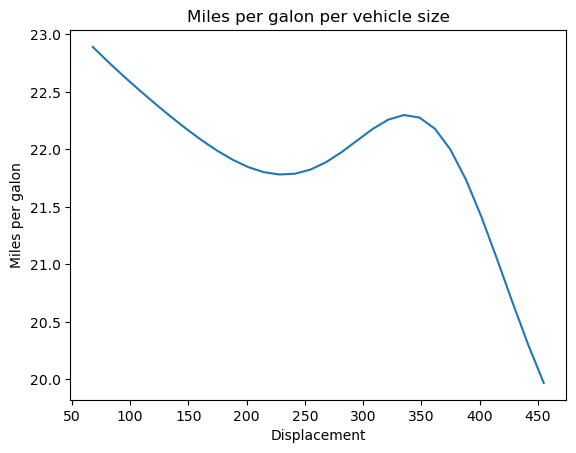

In [16]:
X_design = X.copy()
X_design_vec = pd.DataFrame(X_design.median()).transpose()
    
min_resultant = min(X.loc[:, 'displacement'])
max_resultant = max(X.loc[:, 'displacement'])
seq = np.linspace(start= min_resultant, stop= max_resultant, num= 30)

to_predict = []
for result in seq:
    X_design_vec.loc[0, 'displacement'] = result
    to_predict.append(X_design_vec.copy())

to_predict = pd.concat(to_predict)

to_predict = scaler.transform(to_predict)
preds = mlpr1.predict(to_predict)

plt.plot(seq, preds)
plt.xlabel('Displacement')
plt.ylabel('Miles per galon')
plt.title('Miles per galon per vehicle size')

plt.show()

### The reponse curve indicates an inversely proportional relationship between displacement and fuel efficiency. Larger displacements lead to a lower fuel efficiency. 
### In order to maintain fuel efficient cars we need to ensure that the displacement remains lower than 350, displacement values higher than that leads to inefficient performance in vehicles. These measures can be used as design guidelines for automotive industries to maximise the power of a vehicles while maintaining fuel efficiency.
### **Consequences of using an overfitted model**
### If the model was overfitted, we would likely obtain inaccurate results that leads to suggesting much higher displacement values for a certain range of fuel efficiency. This results to unexpected performances in vehicles.
### This further causes an issue of wasted resources as manufacturers will dedicate time, money and personnel on inaccurate designs and features without gaining the benefits of fuel efficient cars.
### Such problems can cause ripple effects such as reputational damage.